In [64]:
import numpy as np
import networkx as nx
import osmnx as ox
import pandas as pd
import sklearn

# Danger Metric Definition

So, we have our map of Manhattan below 34th St and a dataset of the average number of crashes encountered for each of those datasets. Let's start by loading those and displaying them.

In [2]:
crash_df = pd.read_csv('../../data/DUMMY_CRASH_AVG_FOR_CORRELATION_TESTS_node_id_census_tract_key.csv')
crash_df.head()

,Unnamed: 0,CRASH_AVG,NODE_ID,CENSUS_TRACT_ID
0,0,0.000000,42421828,2800
1,1,0.000000,42421837,2800
2,27,0.000272,42421877,6300
3,52,0.000032,42421889,7100
4,72,0.000000,42421927,5502


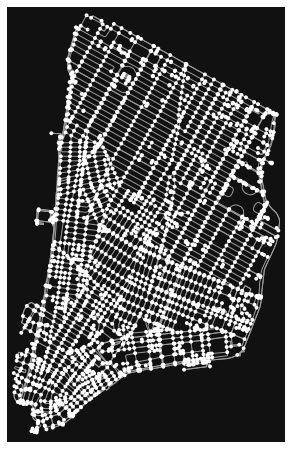

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [3]:
G = ox.io.load_graphml('../../data/mnh_below_34th.graphml')
ox.plot_graph(G)

Cool. Now that we have these two datasets, let's try displaying the average number of crashes for each node.

In [5]:
crash_avg_by_node = crash_df.set_index('NODE_ID')['CRASH_AVG']

def saturate_nodes(G, s):
    for node_id in G.nodes:
        if node_id in s.index:
            continue
        else:
            s.loc[node_id] = 0
    return s

crash_avg_by_node = saturate_nodes(G, crash_avg_by_node)

<AxesSubplot:>

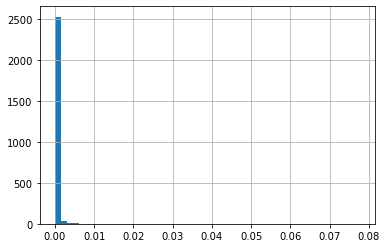

In [51]:
crash_avg_by_node.hist(bins=50)

It looks like the vast, vast majority of intersections had no crashes. Let's switch to a log scale, add a bias of 1, and scale up the non-zero crash averages by several orders of magnitude. This will keep all of the places that have zero crashes at 0 but make the bias not skew the relative results for anywhere else.

<AxesSubplot:>

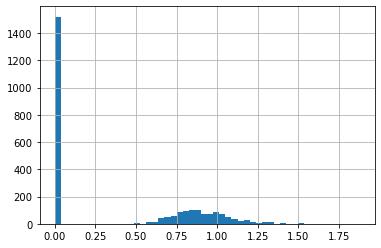

In [47]:
scaled_crash_avg_by_node = np.log(crash_avg_by_node * 1e6 + 1)
scaled_crash_avg_by_node.hist(bins=50)

Now we have a much more visible normal distribution for the nodes that had any crashes. For better interpretability of the results, let's now try filtering off all of the 0 crash-intersections.

<AxesSubplot:>

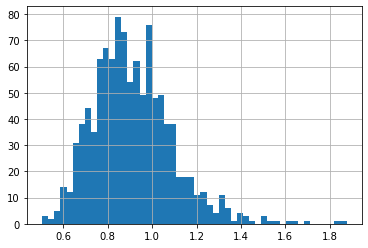

In [77]:
scaled_crash_avg_by_node[scaled_crash_avg_by_node > 0].hist(bins=50)

We scan see a clear normal distribution here with some outlier intersections with more crashes. This scaling process that we did here is a little bit non-standard. Let's use a standard sklearn scaler that does a similar transormation to what we did here but a little more robustly; `PowerTransformer`. We'll again also remove all of the nodes with exactly 0 crashes reported for them.

<AxesSubplot:>

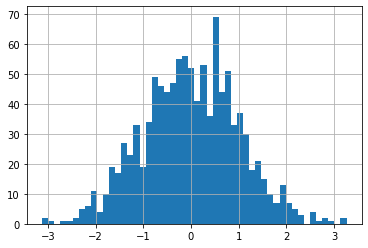

In [155]:
scaler = sklearn.preprocessing.PowerTransformer(method='box-cox')
df = pd.DataFrame(crash_avg_by_node)
scaled_crash_avg_by_node = pd.Series(scaler.fit_transform(df[df.CRASH_AVG > 0])[:, 0])
scaled_crash_avg_by_node.index = df[df.CRASH_AVG > 0].index
scaled_crash_avg_by_node.hist(bins=50)

Sweet. This is a delightfully low-skew normal distribution. Let's try putting it on the map to see if anything stands out.

In [156]:
scaled_crash_avg_by_node.shape

(1067,)

First, we need to keep in mind that we've removed about half of the intersections (which had 0 reported crashes) and that because the scaling centered the data around mean 0, we need to make sure we don't confuse the mean average crash amount with an average crash amount of 0. So what we'll do is shift the whole graph over so that the lowest value in the scaled graph is at 0 (or maybe slightly above 0) and then add back in all of the nodes that really do have a crash average of 0.

We are going to call this offset, scaled, power transformed value of the average crashes each node historically encountered as our "danger metric".

In [157]:
danger_by_node = scaled_crash_avg_by_node + np.abs(scaled_crash_avg_by_node.min())
danger_by_node = saturate_nodes(G, danger_by_node)

# Danger Metric Analysis

In [162]:
danger_by_node

NODE_ID
42421877      3.373220
42421889      0.776015
42421941      1.711781
42422026      2.479361
42422028      4.148776
                ...   
9143569898    0.000000
9143574624    0.000000
9149294704    0.000000
9165725162    0.000000
9165725163    0.000000
Length: 2587, dtype: float64

In [164]:
danger_by_node.describe()

count    2587.000000
mean        1.286012
std         1.664177
min         0.000000
25%         0.000000
50%         0.000000
75%         2.862664
max         6.376098
dtype: float64

In [165]:
danger_by_node[danger_by_node > 0].describe()

count    1066.000000
mean        3.120931
std         0.996364
min         0.036026
25%         2.440177
50%         3.105184
75%         3.804037
max         6.376098
dtype: float64

<AxesSubplot:>

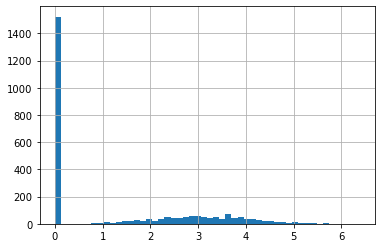

In [161]:
danger_by_node.hist(bins=50)

<AxesSubplot:>

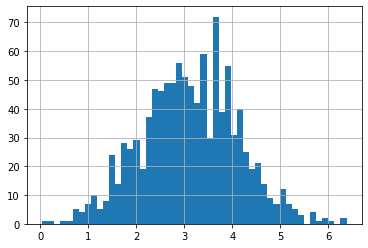

In [166]:
danger_by_node[danger_by_node > 0].hist(bins=50)

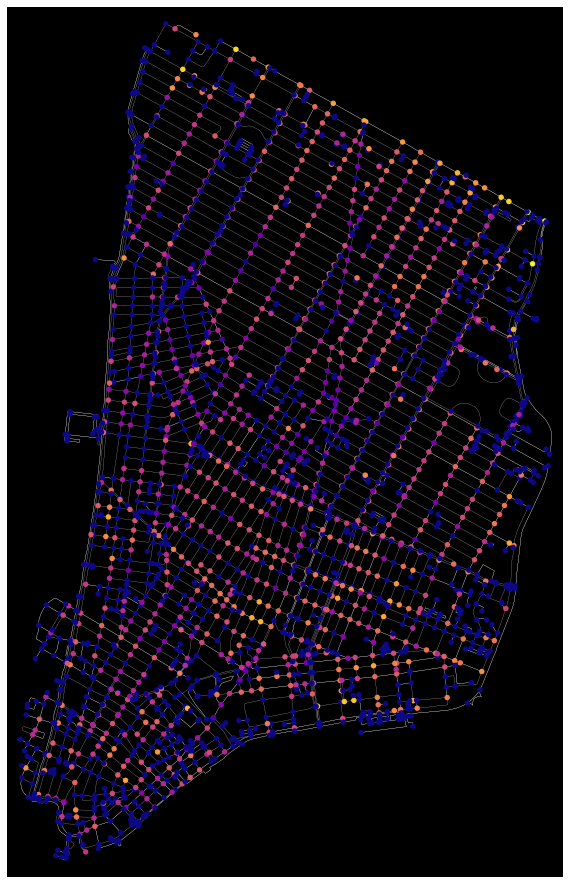

(<Figure size 1152x1152 with 1 Axes>, <AxesSubplot:>)

In [167]:
# Now we set the node attributes to be this crash count
nx.set_node_attributes(G, dict(danger_by_node), "danger")
# Now we map these to colors
nc = ox.plot.get_node_colors_by_attr(G, "danger", cmap="plasma")
# Now we plot the graph with the colors
ox.plot_graph(
    G,
    figsize=(16, 16),
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
    bgcolor="k",
)

This danger metric can be interpreted as having a bimodal distribution with one distribution centered acutely around a mean of 0 (Distribution A) and the other with a mean of around 3.12 (Distribution B).

A represents the intersections for which a crash was never encountered. This data is difficult to interpret as it is very hard to prove whether this is evidence of a counterfactual or evidence of missing data. B may provide evidence that A is simply missed data or mismatched nodes, as B is highly normal and suggests that, if bike traffic and car traffic are anywhere close to uniformly distributed across Manhattan, that we would expect all intersections to have a danger around 3.12.

We can see some artifacts of our data cleanup that may be contributing to the size of distribution A.
1. All crash examples that occurred near an intersection that had separated bike lanes for each direction of traffic had the crash get "sucked" to one lane or the other. This was not done in any principled way that might reflect a difference in the danger of one traffic direction on the other.
2. In parts of the map where intersections are more irregular and more closely spaced, this also leads to many intersections with no crashes being interspersed with intersections with high numbers of crashes. This would probably highly affect our ability to make strong spatial correlations.
3. Edge effects are clearly still present along 34th St. Most of the highest average crash rates are along this street.

Thoughts for additional steps:
1. We should probably consolidate the intersections that are extremely close to one another and use the highest-determined danger value for each intersection grouping. This would help reduce the size of distribution A significantly by addressing problems (1) and (2) above.
2. We should probably just remove the nodes along 34th St. Their data is comprimised by them absorbing all crashes that were attrbiutable to the larger map but cut off and there's not much useful that we can do about that.